In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rcParams['text.usetex'] = True

import numpy as np
from scipy.interpolate import interp1d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [2]:
data_dir = "../data/"

In [3]:
# First let us load the profile likelihood cube
LL_rad_bins_mass = np.load(data_dir + "LL_cube.npy") #these are 2*log(likelihood) values
mH_array = np.load(data_dir + "mH_array.npy") #higgsino masses in units of GeV
Asig_array = np.load(data_dir + "Asig_array.npy") #cross-section values, in units of 1e-26 cm^3/s

# now let us load the J-factor information needed to interpret this data
r_inners = np.load(data_dir + "r_inners.npy")
J_array_NFW = np.load(data_dir + "J_array_NFW.npy")

Above, `LL_rad_bins_mass` is a data cube that contains 2*log(likelihood) values in each radial annulus and for each mass in `mH_array` and for each signal strength parameter in `Asig_array`. 

`Asig_array`: Units are $10^{-26}$ cm$^3$/s

`mH_array`: Units are GeV

`LL_rad_bins_mass[i,j,k]`: `i` selects the higgsino mass, `j` the radial bin, and `k` the signal strength

Note that the signal strength is normalized for the NFW profile J-factor that is given in `J_array_NFW`. The radial bins are given in `r_inners`, which gives the inner bin edges of each radial bin. (We do not use the first bin, which goes from 0 to 1 degrees)

# Constructing a joint likelihood

Below, we show how to use the data cube to construct a joint likelihood over the inner 9 radial annuli.

First, let us look at which annuli we are using and their corresponding J-factors

In [13]:
for i in range(1,10):
    print("annulus is from ", r_inners[i]," to ",r_inners[i+1], " degrees from the GC")
    print("J-factor is ",J_array_NFW[i], " GeV^2/cm^5")
    print("-------------")

annulus is from  1  to  2  degrees from the GC
J-factor is  1.606774931855554e+24  GeV^2/cm^5
-------------
annulus is from  2  to  3  degrees from the GC
J-factor is  9.594159974696395e+23  GeV^2/cm^5
-------------
annulus is from  3  to  4  degrees from the GC
J-factor is  6.518144213291028e+23  GeV^2/cm^5
-------------
annulus is from  4  to  5  degrees from the GC
J-factor is  4.8162984761052215e+23  GeV^2/cm^5
-------------
annulus is from  5  to  6  degrees from the GC
J-factor is  3.7523821586844866e+23  GeV^2/cm^5
-------------
annulus is from  6  to  7  degrees from the GC
J-factor is  3.030390575016227e+23  GeV^2/cm^5
-------------
annulus is from  7  to  8  degrees from the GC
J-factor is  2.5119689315049502e+23  GeV^2/cm^5
-------------
annulus is from  8  to  9  degrees from the GC
J-factor is  2.1202481685009542e+23  GeV^2/cm^5
-------------
annulus is from  9  to  10  degrees from the GC
J-factor is  1.8187332816093062e+23  GeV^2/cm^5
-------------


The functions below construct the joint likelihood, at a fixed mass index `mH_index`, by summing over the likelihood values in each of the annuli. `joint_likelihood_array` accepts either a scalar or an array of signal strength parameters `Asig`.

In [49]:
def joint_likelihood(mH_index,Asig):
    '''
    mH_index: the index for the higgsino mass (from mH_array)
    Asig: the signal strength parameter in units of 1e-26 cm^3/s
    returns: -2*log(likelihood)
    '''
    shape = np.shape(Asig)
    LL_tmp = LL_rad_bins_mass[mH_index] 
    LL_tot = 0.0
    for i in range(1,10):
        LL_tot += interp1d(Asig_array,LL_tmp[i])(Asig)
    return LL_tot
    
def joint_likelihood_array(mH_index,Asig):
    '''
    mH_index: the index for the higgsino mass (from mH_array)
    Asig: the signal strength parameter in units of 1e-26 cm^3/s. This can be an array for this function!
    returns: -2*log(likelihood)
    '''
    shape = np.shape(Asig)
    if len(shape)==0:
        return joint_likelihood(mH_index,Asig)
    else:
        NA = len(Asig)
        res = np.zeros(NA)
        for i in range(NA):
            res[i] = joint_likelihood(mH_index,Asig[i])
        return res
        

# Examples: computing joint likelihoods, best-fits, and upper limits

As an example, we take `mH_index = 6`, corresponding to around a 1.1 TeV higgsino. We compute the joint likelihood and use it to find the best-fit cross-section and the 95\% one-sided upper limit

In [30]:
mH_index = 6
print("For this example, the higgsino mass is ",mH_array[mH_index])

For this example, the higgsino mass is  1133.3333333333333


In [50]:
# Here we call the joint likelihood function, over annuli, and compute the best-fit and 95% one-sided U.L.
LL_joint_example = joint_likelihood_array(mH_index,Asig_array)
best_fit = Asig_array[np.argmin(LL_joint_example)]
UL = Asig_array[np.where(LL_joint_example - np.min(LL_joint_example) <2.71)[0][-1]]

### Plot the result

Text(0, 0.5, '$-2 \\log p/p_0$')

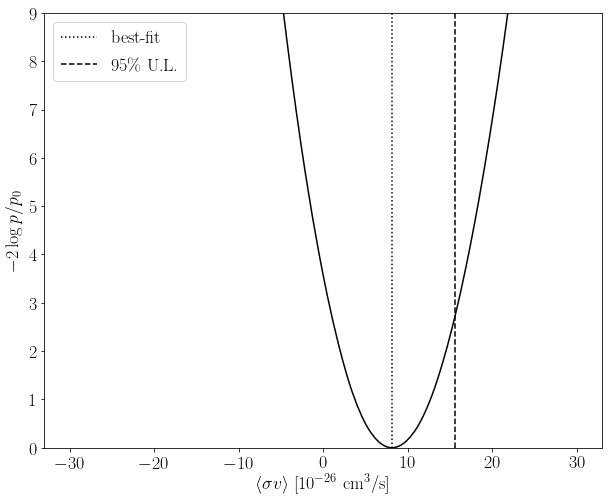

In [51]:
fig = plt.figure(figsize=(10,8))
plt.plot(Asig_array,LL_joint_example-np.min(LL_joint_example),'k-')
plt.axvline(best_fit,color="black",label="best-fit",linestyle="dotted")
plt.axvline(UL,color="black",label="95\% U.L.",linestyle="dashed")
plt.ylim(0,9)
plt.legend(fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$\langle \sigma v\rangle$ [$10^{-26}$ cm$^3$/s]",fontsize=18)
plt.ylabel(r"$-2 \log p/p_0$",fontsize=18)